In [10]:
import torch
import torchvision
from torchvision.models import resnet50

In [11]:
# add parent dir for loading helpers
import sys
sys.path.insert(1, '../')

In [12]:
rgb_weights = torch.load("../models/rgb_3c_model_89.pth", map_location='cpu', weights_only=False)
rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
rgb_model.load_state_dict(rgb_weights["model"])
# rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

<All keys matched successfully>

In [13]:
rgb_model = torchvision.models.get_model("resnet50", weights=None, num_classes=1000)
rgb_model.load_state_dict(rgb_weights["model"])

rgb_model = torch.nn.Sequential(*list(rgb_model.children())[:9])

In [15]:
# model2_backbone = torch.nn.Sequential(*list(full_model.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
# model2_comparable = nn.Sequential(model2_backbone, model2_classifier)

from helpers import radimagenet
from torch import nn

backbone = radimagenet.RadImageNetBackbone()
classifier = radimagenet.RadImageNetClassifier(num_class=1)

backbone.load_state_dict(torch.load("../models/radimagenet_resnet50.pt"))
model2_backbone = torch.nn.Sequential(*list(backbone.children())[:9])
# model2_classifier = RadImageNetClassifier(num_class=num_class)
model2_comparable = nn.Sequential(model2_backbone, classifier)

## Load Data

In [6]:
from torchvision.transforms import v2
from torch import float32 as tfloat32

# crop dictionary of calculated dataset means and std devs
CROP_DICT = {
    # data      mean         std
    'cxr14': [[162.7414], [44.0700]],
    'openi': [[157.6150], [41.8371]],
    'jsrt': [[161.7889], [41.3950]],
    'padchest': [[160.3638], [44.8449]],
}

# arch segmented dictionary of calculated dataset means and std devs
ARCH_SEG_DICT = {
    # data       mean        std
    'cxr14': [[128.2716], [76.7148]],
    'openi': [[127.7211], [69.7704]],
    'jsrt': [[139.9666], [72.4017]],
    'padchest': [[129.5006], [72.6308]],
    'padcxr14': [[128.8861], [74.6728]]
}

# lung segmented dictionary of calculated dataset means and std devs
LUNG_SEG_DICT = {
    # data       mean        std
    'cxr14': [[60.6809], [68.9660]],
    'openi': [[60.5483], [66.5276]],
    'jsrt': [[66.5978], [72.6493]],
    'padchest': [[60.5482], [66.5276]],
    'padcxr14': [[60.61455], [67.7468]]
}


def get_cxr_eval_transforms(crop_size, normalise):
    """
    Returns evaluation transforms for CXR images. Pass in target 
    crop size and the normalisation method for target dataset.
    """
    cxr_transform_list = [
        v2.ToImage(),
        v2.Resize(size=crop_size, antialias=True),
        v2.ToDtype(tfloat32, scale=False),
        normalise
    ]
    return v2.Compose(cxr_transform_list)


def get_cxr_single_eval_transforms(crop_size, normalise):
    """
    Returns evaluation transforms for single channel output CXR 
    images. Pass in target crop size and the normalisation method 
    for target dataset.
    """
    cxr_transform_list = [
        v2.ToImage(),
        v2.Grayscale(1),
        v2.Resize(size=crop_size, antialias=True),
        v2.ToDtype(tfloat32, scale=False),
        normalise,
    ]
    return v2.Compose(cxr_transform_list)


def get_cxr_dataset_normalisation(dataset, process):
    """
    Returns normalisation transform for given dataset/config. Pass 
    in dataset name and the image processing method used.

    Args:
    - dataset (str): Name of CXR dataset. Expects ("cxr14", "padchest", "openi", "jsrt").
    - process (str): Name of CXR processing applied. Expects ("crop", "arch", "lung").

    Returns:
    - torchvision.transform.V2 normalize method.

    """
    if process.lower() not in ("crop", "arch", "lung"):
        raise ValueError(f"Unexpected CXR processing type: \
            {process}! Please choose from (crop, arch, lung).")
    else:
        if dataset.lower() not in ("cxr14", "padchest", "openi", "jsrt"):
            raise ValueError(f"Unexpected CXR dataset type: \
                {dataset}! Please choose from (cxr14, padchest, \
                openi, jsrt).")
        else:
            return v2.Normalize(CROP_DICT[dataset.lower()][0],
                                CROP_DICT[dataset.lower()][1]) \
                if process.lower() == "crop" \
                else \
                v2.Normalize(ARCH_SEG_DICT[dataset.lower()][0],
                             ARCH_SEG_DICT[dataset.lower()][1]) \
                if process.lower() == "arch" \
                else v2.Normalize(LUNG_SEG_DICT[dataset.lower()][0],
                                  LUNG_SEG_DICT[dataset.lower()][1])



## Create Custom Dataset

In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from tqdm import tqdm
import torch

class ImagePairDataset(Dataset):
    """Custom dataset for loading image pairs organized as:
    root/class_name/pair_name/lung_l.png
    root/class_name/pair_name/lung_r.png
    """
    
    def __init__(self, root, transform=None, image_names=('lung_l.png', 'lung_r.png')):
        """
        Args:
            root (str): Root directory path
            transform: torchvision transforms to apply to both images
            image_names (tuple): Names of the two images in each pair folder
        """
        self.root = root
        self.transform = transform
        self.image_names = image_names
        
        # Build the dataset index
        self.pairs = []
        self.class_to_idx = {}
        self._build_dataset()
        
    def _build_dataset(self):
        """Build list of all image pairs and create class mappings"""
        classes = sorted([d for d in os.listdir(self.root) 
                         if os.path.isdir(os.path.join(self.root, d))])
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for class_name in tqdm(classes, desc="Loading dataset"):
            class_path = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all pair directories in this class
            pair_dirs = [d for d in os.listdir(class_path) 
                        if os.path.isdir(os.path.join(class_path, d))]
            
            for pair_name in pair_dirs:
                pair_path = os.path.join(class_path, pair_name)
                
                # Check if both images exist
                lungl_path = os.path.join(pair_path, self.image_names[0])
                lungr_path = os.path.join(pair_path, self.image_names[1])
                # print(f"lungl_path: {lungl_path}")
                # print(f"lungr_path: {lungr_path}")
                if os.path.exists(lungl_path) and os.path.exists(lungr_path):
                    self.pairs.append({
                        'class_name': class_name,
                        'class_idx': class_idx,
                        'pair_name': pair_name,
                        'lungl_path': lungl_path,
                        'lungr_path': lungr_path
                    })
                else:
                    print(f"Warning: Missing images in {pair_path}")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        """
        Returns:
            tuple: (lungl, lungr, class_idx, lungl_path, lungr_path)
        """
        pair_info = self.pairs[idx]

        print(f"PAIR INFO: {pair_info}")
        # Load images
        lungl = Image.open(pair_info['lungl_path']).convert('RGB')
        lungr = Image.open(pair_info['lungl_path']).convert('RGB')
        
        # Apply transforms
        if self.transform:
            lungl = self.transform(lungl)
            lungr = self.transform(lungr)
        
        return (
            lungl, 
            lungr, 
            pair_info['class_idx'],
            pair_info['lungl_path'],
            pair_info['lungr_path']
        )
    
    def get_class_name(self, class_idx):
        """Get class name from class index"""
        idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        return idx_to_class[class_idx]
    
    def get_pairs_by_class(self, class_name):
        """Get all pairs for a specific class"""
        return [pair for pair in self.pairs if pair['class_name'] == class_name]
    
    def print_dataset_info(self):
        """Print dataset statistics"""
        print(f"Total pairs: {len(self.pairs)}")
        print(f"Number of classes: {len(self.class_to_idx)}")
        
        # Count pairs per class
        class_counts = {}
        for pair in self.pairs:
            class_name = pair['class_name']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        print("\nPairs per class:")
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count}")


def load_image_pair_dataset(dataset_path, crop_size=512, batch_size=4, 
                           shuffle=True, transform=None, image_names=('lung_l.png', 'lung_r.png')):
    """
    Wrapper function to load image pair dataset with DataLoader
    
    Args:
        dataset_path (str): Path to dataset root
        crop_size (int): Size for image cropping/resizing
        batch_size (int): Batch size for DataLoader
        shuffle (bool): Whether to shuffle the dataset
        transform: Custom transform, if None will use default ResNet50 transforms
        image_names (tuple): Names of the two images in each pair folder
    
    Returns:
        DataLoader: Configured DataLoader for the dataset
    """
    
    # Default ResNet50 transforms if none provided
    if transform is None:
        from torchvision import transforms
        transform = transforms.Compose([
            transforms.Resize((crop_size, crop_size)),
            transforms.ToTensor(),
            # transforms.Normalize(
            #     mean=[0.485, 0.456, 0.406],  # ImageNet means
            #     std=[0.229, 0.224, 0.225]    # ImageNet stds
            # )
        ])
    
    dataset = ImagePairDataset(
        root=dataset_path,
        transform=transform,
        image_names=image_names
    )
    
    # Print dataset info
    dataset.print_dataset_info()
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Example usage:
# if __name__ == "__main__":
# Test the dataset
dataset_path = "../legacy_split_node21"

# Load with default settings
dataloader = load_image_pair_dataset(
    dataset_path=dataset_path,
    batch_size=8,
    crop_size=224  # Standard ResNet50 input size
)

# Test loading a batch
for batch_idx, (lungl, lungr, class_idx, path1, path2) in enumerate(dataloader):
    print(f"Batch {batch_idx}:")
    print(f"  lungl shape: {lungl.shape}")
    print(f"  lungr shape: {lungr.shape}")
    print(f"  Class indices: {class_idx}")
    print(f"  Sample paths: {path1[0]}, {path2[0]}")
    if batch_idx == 0:  # Just show first batch
        break

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Total pairs: 3688
Number of classes: 2

Pairs per class:
  nodule: 1060
  normal: 2628
PAIR INFO: {'class_name': 'nodule', 'class_idx': 0, 'pair_name': 'n0072', 'lungl_path': '../legacy_split_node21/nodule/n0072/lung_l.png', 'lungr_path': '../legacy_split_node21/nodule/n0072/lung_r.png'}
PAIR INFO: {'class_name': 'nodule', 'class_idx': 0, 'pair_name': 'n0402', 'lungl_path': '../legacy_split_node21/nodule/n0402/lung_l.png', 'lungr_path': '../legacy_split_node21/nodule/n0402/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c3031', 'lungl_path': '../legacy_split_node21/normal/c3031/lung_l.png', 'lungr_path': '../legacy_split_node21/normal/c3031/lung_r.png'}
PAIR INFO: {'class_name': 'normal', 'class_idx': 1, 'pair_name': 'c1560', 'lungl_path': '../legacy_split_node21/normal/c1560/lung_l.png', 'lungr_path': '../legacy_split_node21/normal/c1560/lung_r.png'}
PAIR INFO: {'class_name': 'nodule', 'class_idx': 0, 'pair_name': 'n0289', 'lungl_path': '../legacy_split_

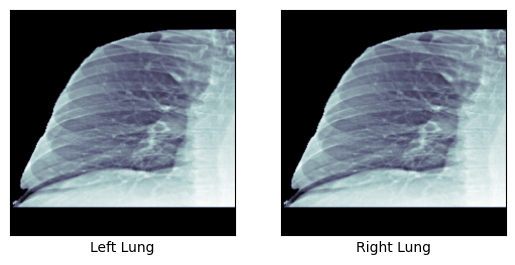

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.setp(ax.get_xticklabels(),visible=(False))
plt.setp(ax.get_yticklabels(),visible=(False))
ax.imshow(lungl[0][0],cmap="bone")
ax.set_xlabel('Left Lung')
ax.tick_params(axis='both', which='both', length=0)

ax2 = fig.add_subplot(1,2,2)
plt.setp(ax2.get_xticklabels(),visible=(False))
plt.setp(ax2.get_yticklabels(),visible=(False))
# ax2.imshow(np.flip(lung_r, axis=1),cmap="bone")
ax2.imshow(lungl[0][0],cmap="bone")

ax2.set_xlabel('Right Lung')
ax2.tick_params(axis='both', which='both', length=0)